In [25]:
import numpy as np
import matplotlib.pyplot as plt

# ML-based classificaiton
Uses data from the `preprocessed.p` file  generated by the [pre-processing notebook](preprocessing.ipynb).

Shapes:
- X: `(subject, trials, components, bands)`
- y: `(subject, trials)`

Therefore:
- Sample: **PCA component**
- Feature: **Average band power**

## Import EEG data

In [26]:
import pickle

with open('preprocessed.p', 'rb') as f:
    X, y = pickle.load(f)

n_subjects = X.shape[0]
for i, subj in enumerate(X):
    n_trials, n_components, n_bands = subj.shape
    print(f"Subject {i+1}: {n_trials} trials, {n_components} components, {n_bands} bands average power")

Subject 1: 434 trials, 6 components, 2 bands average power
Subject 2: 434 trials, 6 components, 2 bands average power
Subject 3: 434 trials, 6 components, 2 bands average power
Subject 4: 434 trials, 6 components, 2 bands average power
Subject 5: 434 trials, 6 components, 2 bands average power
Subject 6: 434 trials, 6 components, 2 bands average power


## SVM
Linear model used for its convenience as a performance baseline

In [27]:
# rows = one per trial and subject, columns = features (average power of two bands for each component)
X_svm = X.reshape(n_subjects * n_trials, n_components * n_bands)  
y_svm = y.reshape(n_subjects * n_trials)
# for each row, which subject it belongs to
subject_ids = np.repeat(np.arange(n_subjects), n_trials)  # shape = (n_subjects * n_trials,)

### Evaluation on generalization (LeaveOneGroupOut)
Performs poorly

In [28]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.svm import SVC

scores = [] # one accuracy score per subject left out
for train_idx, test_idx in LeaveOneGroupOut().split(X_svm, y_svm, groups=subject_ids):  # number of iterations = n_subjects
    X_train, X_test = X_svm[train_idx], X_svm[test_idx]
    y_train, y_test = y_svm[train_idx], y_svm[test_idx]

    print("\nSubject left out for testing:", subject_ids[test_idx[0]])
    print(f"Training on {X_train.shape[0]} samples, testing on {X_test.shape[0]} samples")
    print("Training set class distribution (0s and 1s):", np.bincount(y_train))
    print("Testing set class distribution (0s and 1s):", np.bincount(y_test))

    clf = SVC(kernel='linear')
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print("Testing set predictions accuracy:", score)
    scores.append(score)

print("\nAverage cross-subject accuracy:", np.mean(scores))


Subject left out for testing: 0
Training on 2170 samples, testing on 434 samples
Training set class distribution (0s and 1s): [1127 1043]
Testing set class distribution (0s and 1s): [217 217]
Testing set predictions accuracy: 0.7741935483870968

Subject left out for testing: 1
Training on 2170 samples, testing on 434 samples
Training set class distribution (0s and 1s): [1106 1064]
Testing set class distribution (0s and 1s): [238 196]
Testing set predictions accuracy: 0.6935483870967742

Subject left out for testing: 2
Training on 2170 samples, testing on 434 samples
Training set class distribution (0s and 1s): [1122 1048]
Testing set class distribution (0s and 1s): [222 212]
Testing set predictions accuracy: 0.5898617511520737

Subject left out for testing: 3
Training on 2170 samples, testing on 434 samples
Training set class distribution (0s and 1s): [1123 1047]
Testing set class distribution (0s and 1s): [221 213]
Testing set predictions accuracy: 0.5345622119815668

Subject left ou

### Evaluation on subject isolation (Two-Layer K-fold CV)
Better performance and more reliability of results

In [29]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="linear"))
])

# Parameters that will be tested in the inner cross-validation:
# for each outer fold, the inner CV will select the best C among these values
param_grid = {
    "svm__C": [0.01, 0.1, 1, 10]    # Possible values for the SVM regularization parameter C
}

scores = []     # to store the accuracy scores from each outer fold
best_Cs = []    # to store the best C found in each outer fold
for train_idx, test_idx in outer_cv.split(X_svm, y_svm):
    X_train, X_test = X_svm[train_idx], X_svm[test_idx]
    y_train, y_test = y_svm[train_idx], y_svm[test_idx]

    grid = GridSearchCV(
        pipe,
        param_grid,
        cv=inner_cv,
        scoring="accuracy"
    )

    grid.fit(X_train, y_train)
    scores.append(grid.score(X_test, y_test))
    best_Cs.append(grid.best_params_["svm__C"])

    print(f"\nOuter fold {len(scores)}:")
    print(f"Training on {X_train.shape[0]} samples, testing on {X_test.shape[0]} samples")
    print("Training set class distribution (0s and 1s):", np.bincount(y_train))
    print("Testing set class distribution (0s and 1s):", np.bincount(y_test))
    print("Mean accuracy on test set:", scores[-1])
    print("Best C found in inner CV:", best_Cs[-1])

print("\nOverall average accuracy across outer folds:", np.mean(scores))


KeyboardInterrupt: 

In [ ]:
X.shape

(6, 434, 6, 2)

## FNN

In [ ]:
import torch
from sklearn.model_selection import StratifiedKFold
import torch.nn as nn
import torch.nn.functional as F

# rows = one per trial and subject, columns = features (average power of two bands for each component)
X_dnn = torch.tensor(X.reshape(n_subjects * n_trials, n_components * n_bands), dtype=torch.float32)
y_dnn = torch.tensor(y.reshape(n_subjects * n_trials), dtype=torch.long)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, n_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ELU(),
            nn.Dropout(0.1),
            
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Dropout(0.1),
            
            nn.Linear(64, n_classes)
        )
    
    def forward(self, x):
        return self.model(x)

# Hyperparameters
lr = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer_class = torch.optim.Adam

(6, 434, 6, 1536)

In [ ]:
# Training loop
EPOCHS = 1000
EPOCH_CHECKPOINT = EPOCHS // 10

train_losses, val_losses = np.zeros((cv.get_n_splits(), EPOCHS // EPOCH_CHECKPOINT)), np.zeros((cv.get_n_splits(), EPOCHS // EPOCH_CHECKPOINT))
train_accs, val_accs = np.zeros((cv.get_n_splits(), EPOCHS // EPOCH_CHECKPOINT)), np.zeros((cv.get_n_splits(), EPOCHS // EPOCH_CHECKPOINT))

for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X_dnn, y_dnn)):
    X_train, X_test = X_dnn[train_idx], X_dnn[test_idx]
    y_train, y_test = y_dnn[train_idx], y_dnn[test_idx]
    
    net = Net(input_size=X_dnn.shape[1], n_classes=2)
    optimizer = optimizer_class(net.parameters(), lr=lr)
    
    print(f"\nFold {fold_idx + 1}:")
    for epoch in range(EPOCHS):
        net.train()
        optimizer.zero_grad()
        logits = net(X_train)
        loss = criterion(logits, y_train)
        acc = (logits.argmax(1) == y_train).float().mean()
        loss.backward()
        optimizer.step()

        if epoch % EPOCH_CHECKPOINT == 0:
            net.eval()
            with torch.no_grad():
                val_logits = net(X_test)
                val_loss = criterion(val_logits, y_test)
                val_acc = (val_logits.argmax(1) == y_test).float().mean()
                train_losses[fold_idx, epoch // EPOCH_CHECKPOINT] = loss.item()
                val_losses[fold_idx, epoch // EPOCH_CHECKPOINT] = val_loss.item()
                train_accs[fold_idx, epoch // EPOCH_CHECKPOINT] = acc.item()
                val_accs[fold_idx, epoch // EPOCH_CHECKPOINT] = val_acc.item()
                print(f"Epoch {epoch}: loss={loss:.3f}, acc={acc:.3f}, val_loss={val_loss:.3f}, val_acc={val_acc:.3f}")

# Average across folds for each epoch checkpoint
train_losses_mean = train_losses.mean(axis=0)
val_losses_mean = val_losses.mean(axis=0)
train_accs_mean = train_accs.mean(axis=0)
val_accs_mean = val_accs.mean(axis=0)


Fold 1:
Epoch 0: loss=0.782, acc=0.517, val_loss=0.703, val_acc=0.491
Epoch 100: loss=0.583, acc=0.701, val_loss=0.597, val_acc=0.702
Epoch 200: loss=0.564, acc=0.719, val_loss=0.577, val_acc=0.706
Epoch 300: loss=0.551, acc=0.722, val_loss=0.558, val_acc=0.706
Epoch 400: loss=0.526, acc=0.732, val_loss=0.549, val_acc=0.710
Epoch 500: loss=0.530, acc=0.717, val_loss=0.544, val_acc=0.729
Epoch 600: loss=0.521, acc=0.736, val_loss=0.537, val_acc=0.735
Epoch 700: loss=0.509, acc=0.744, val_loss=0.535, val_acc=0.735
Epoch 800: loss=0.510, acc=0.737, val_loss=0.533, val_acc=0.733
Epoch 900: loss=0.507, acc=0.753, val_loss=0.531, val_acc=0.729

Fold 2:
Epoch 0: loss=0.688, acc=0.562, val_loss=0.657, val_acc=0.641
Epoch 100: loss=0.577, acc=0.705, val_loss=0.575, val_acc=0.729
Epoch 200: loss=0.554, acc=0.722, val_loss=0.565, val_acc=0.712
Epoch 300: loss=0.538, acc=0.724, val_loss=0.560, val_acc=0.716
Epoch 400: loss=0.526, acc=0.733, val_loss=0.555, val_acc=0.708
Epoch 500: loss=0.512, acc

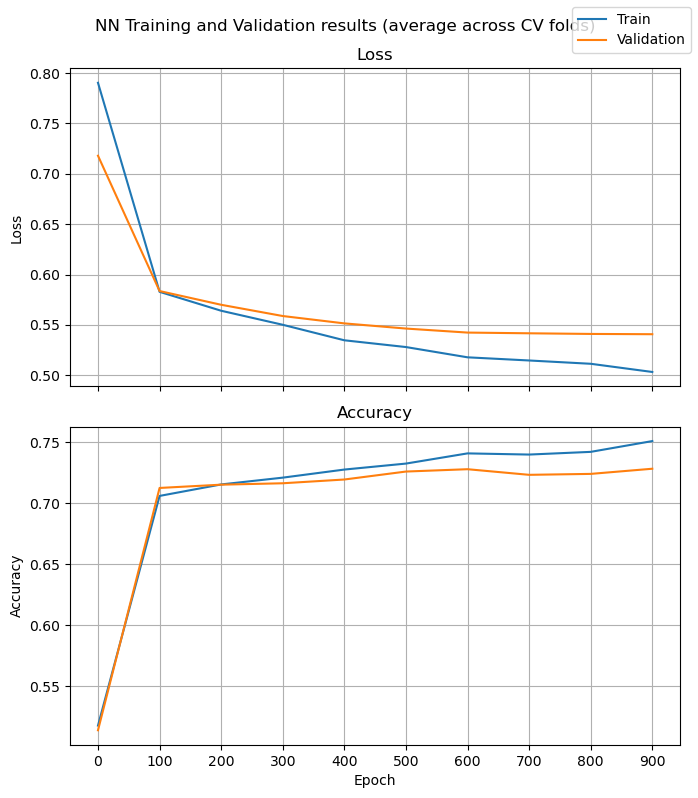

In [ ]:
idxs = range(0, EPOCHS, EPOCH_CHECKPOINT)
fig, axs = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

axs[0].plot(idxs, train_losses_mean, label="Train")
axs[0].plot(idxs, val_losses_mean, label="Validation")
axs[0].set_ylabel("Loss")
axs[0].grid(True)
axs[0].set_title("Loss")

axs[1].plot(idxs, train_accs_mean)
axs[1].plot(idxs, val_accs_mean)
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].grid(True)
axs[1].set_title("Accuracy")
axs[1].set_xticks(idxs)

fig.legend()
fig.suptitle("NN Training and Validation results (average across CV folds)")
fig.tight_layout()
plt.show()

# DL-based classification
Imports the `preprocessed-ts.p` file generated by the [pre-processing notebook](preprocessing.ipynb).

Shapes:
- X: `(subject, trials, components, timepoints)`
- y: `(subject, trials)`

Therefore:
- Sample: **CSP feature**
- Feature: **Individual sample in time**

## Import EEG data

In [ ]:
import pickle

with open('preprocessed-ts.p', 'rb') as f:
    X, y = pickle.load(f)

n_subjects = X.shape[0]
for i, subj in enumerate(X):
    n_trials, n_components, n_samples = subj.shape
    print(f"Subject {i+1}: {n_trials} trials, {n_components} components, {n_samples} timepoints")

Subject 1: 434 trials, 6 components, 1536 timepoints
Subject 2: 434 trials, 6 components, 1536 timepoints
Subject 3: 434 trials, 6 components, 1536 timepoints
Subject 4: 434 trials, 6 components, 1536 timepoints
Subject 5: 434 trials, 6 components, 1536 timepoints
Subject 6: 434 trials, 6 components, 1536 timepoints


## CNN

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# CNN input shape: (n_samples, n_channels, n_timepoints)
X_cnn = torch.tensor(X.reshape(n_subjects * n_trials, n_components, n_samples), dtype=torch.float32)
y_cnn = torch.tensor(y.reshape(n_subjects * n_trials), dtype=torch.long)

# CNN input shape: (n_samples_train, n_channels, n_timepoints) and (n_samples_test, n_channels, n_timepoints)
X_cnn_train, X_cnn_test, y_cnn_train, y_cnn_test = train_test_split(
    X_cnn, y_cnn,
    test_size=0.2,
    random_state=42,
    stratify=y_cnn
)

# CNN input shape: (batch_size, n_channels, n_timepoints) -> ~66 train batches of 32 samples, ~17 test batches of 32 samples
BATCH = 64
train_loader = DataLoader(TensorDataset(X_cnn_train, y_cnn_train), batch_size=BATCH, shuffle=True, num_workers=4)
test_loader  = DataLoader(TensorDataset(X_cnn_test, y_cnn_test), batch_size=BATCH, shuffle=False)

print("X_cnn:", X_cnn.shape, "y_cnn:", y_cnn.shape)
print("X_cnn_train:", X_cnn_train.shape, "y_cnn_train:", y_cnn_train.shape)
for xb, yb in train_loader:
    print(f"Train batch: X={xb.shape}, y={yb.shape}, total batches:", len(train_loader))
    break
for xb, yb in test_loader:
    print(f"Test batch: X={xb.shape}, y={yb.shape}, total batches:", len(test_loader))
    break

X_cnn: torch.Size([2604, 6, 1536]) y_cnn: torch.Size([2604])
X_cnn_train: torch.Size([2083, 6, 1536]) y_cnn_train: torch.Size([2083])
Train batch: X=torch.Size([64, 6, 1536]), y=torch.Size([64]), total batches: 33
Test batch: X=torch.Size([64, 6, 1536]), y=torch.Size([64]), total batches: 9


In [ ]:
# 1D Convolutional Neural Network for time-series classification
class CNN(nn.Module):   
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(n_channels, 16, kernel_size=25, padding=12),  # (B,6,1536)->(B,16,1536)
            nn.BatchNorm1d(16),
            nn.ELU(),
            nn.MaxPool1d(4),                                        # (B,16,1536)->(B,16,384)
            nn.Dropout(0.1),

            nn.Conv1d(16, 32, kernel_size=15, padding=7),           # (B,16,384)->(B,32,384)
            nn.BatchNorm1d(32),
            nn.ELU(),
            nn.MaxPool1d(4),                                        # (B,32,384)->(B,32,96)
            nn.Dropout(0.1),

            nn.Flatten(),                                           # (B,32,96)->(B,32*96)
            nn.Linear(32*96, 128),                                  # (B,3072)->(B,128)
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(128, n_classes) 
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters and model
net = CNN(n_channels=n_components, n_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [ ]:
# Training loop
EPOCHS = 30

train_losses, val_losses = [], []
train_accs, val_accs = [], []
for epoch in range(EPOCHS):
    net.train()
    train_loss, train_acc = 0, 0
    for xb, yb in train_loader:  # Use DataLoader for batching
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = net(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += (logits.argmax(1) == yb).float().mean().item()

    # Average training metrics per epoch
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    net.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            val_logits = net(xb)
            val_loss += criterion(val_logits, yb).item()
            val_acc += (val_logits.argmax(1) == yb).float().mean().item()
    val_loss /= len(test_loader)
    val_acc /= len(test_loader)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    if epoch % (EPOCHS // 10) == 0:
        print(f"Epoch {epoch}: loss={train_loss:.3f}, acc={train_acc:.3f}, val_loss={val_loss:.3f}, val_acc={val_acc:.3f}")

Epoch 0: loss=2.451, acc=0.487, val_loss=0.764, val_acc=0.504
Epoch 3: loss=0.714, acc=0.532, val_loss=0.705, val_acc=0.496
Epoch 6: loss=0.690, acc=0.541, val_loss=0.706, val_acc=0.510
Epoch 9: loss=0.633, acc=0.642, val_loss=0.695, val_acc=0.617
Epoch 12: loss=0.535, acc=0.720, val_loss=0.618, val_acc=0.661
Epoch 15: loss=0.486, acc=0.758, val_loss=0.653, val_acc=0.645
Epoch 18: loss=0.457, acc=0.781, val_loss=0.770, val_acc=0.657
Epoch 21: loss=0.419, acc=0.803, val_loss=0.649, val_acc=0.662
Epoch 24: loss=0.372, acc=0.824, val_loss=0.734, val_acc=0.675
Epoch 27: loss=0.287, acc=0.867, val_loss=0.966, val_acc=0.636


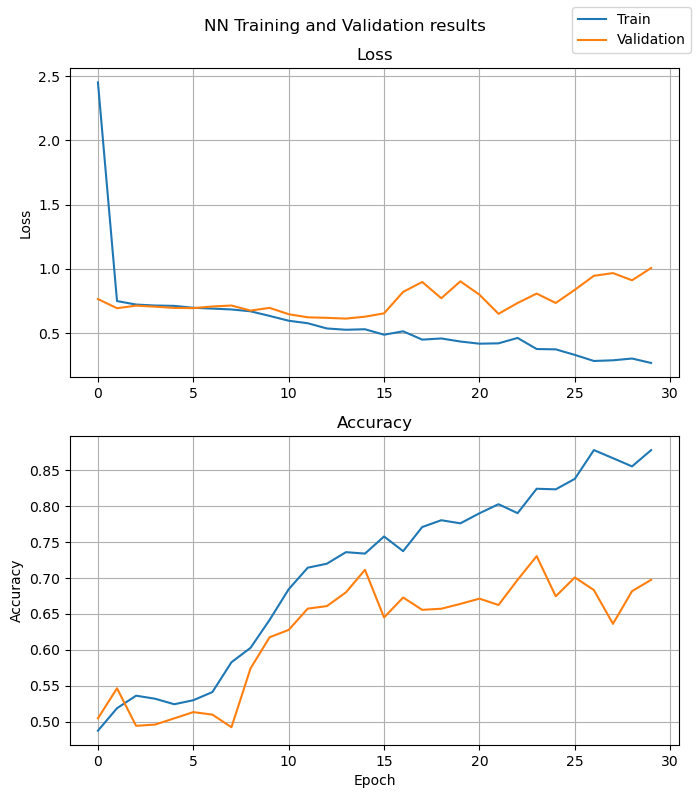

In [ ]:
idxs = range(0, EPOCHS, EPOCHS // 10)
fig, axs = plt.subplots(2, 1, figsize=(7, 8))

axs[0].plot(train_losses, label="Train")
axs[0].plot(val_losses, label="Validation")
axs[0].set_ylabel("Loss")
axs[0].grid(True)
axs[0].set_title("Loss")

axs[1].plot(train_accs)
axs[1].plot(val_accs)
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].grid(True)
axs[1].set_title("Accuracy")

fig.legend()
fig.suptitle("NN Training and Validation results")
fig.tight_layout()
plt.show()